In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")


GPU is available: Tesla P100-PCIE-16GB


In [3]:
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader
import os
import json
import random  # <-- Add this
from tqdm.notebook import tqdm


In [4]:
import os

# Collect all filenames under /kaggle/input, but do NOT print
file_paths = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_paths.append(os.path.join(dirname, filename))

# Optional: Show just how many files were found
print(f"Total files found: {len(file_paths)}")

Total files found: 261080


In [5]:
# Set GPU device
import torch
import os
import torch
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50

# Load pretrained ResNet-50 and remove classification layer
model = resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final FC
model.eval().to(device)

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225])
])

# Dataset directory
dataset_root = '/kaggle/input/polyvore-outfit-dataset/polyvore_outfits'
img_dir = os.path.join(dataset_root, 'images')
image_paths = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir) if fname.endswith(".jpg")]
image_ids = [os.path.splitext(os.path.basename(p))[0] for p in image_paths]

print(f"Total images found: {len(image_paths)}")

# Create custom dataset
class FashionDataset(Dataset):
    def __init__(self, paths, ids, transform):
        self.paths = paths
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        img_id = self.ids[idx]
        try:
            image = Image.open(path).convert("RGB")
            image = self.transform(image)
        except Exception as e:
            print(f"Error loading {path}: {e}")
            image = torch.zeros((3, 224, 224))  # dummy black image
        return img_id, image

# Dataloader with multithreading + prefetching
batch_size = 256  # Adjust this depending on GPU memory
dataset = FashionDataset(image_paths, image_ids, transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Extract features
image_features = {}

for batch_ids, batch_imgs in tqdm(loader):
    batch_imgs = batch_imgs.to(device)

    with torch.no_grad():
        feats = model(batch_imgs)  # shape: (B, 2048, 1, 1)
        feats = feats.squeeze(-1).squeeze(-1) # shape: (B, 2048)

    for img_id, feat in zip(batch_ids, feats):
         image_features[img_id] = feat.detach().clone()

print(f"Extracted features for {len(image_features)} images using GPU!")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s] 


Total images found: 261057


100%|██████████| 1020/1020 [10:20<00:00,  1.64it/s]

Extracted features for 261057 images using GPU!


In [6]:
import json
with open('/kaggle/input/polyvore-outfit-dataset/polyvore_outfits/nondisjoint/train.json', 'r') as f:
    outfit_data = json.load(f)

print(outfit_data[0])         # Prints the first outfit
print(outfit_data[0]['items'])  # Prints the items in that outfit
print(outfit_data[0]['items'][0])  # Prints a single item dictionary

{'items': [{'item_id': '154249722', 'index': 1}, {'item_id': '188425631', 'index': 2}, {'item_id': '183214727', 'index': 3}], 'set_id': '210750761'}
[{'item_id': '154249722', 'index': 1}, {'item_id': '188425631', 'index': 2}, {'item_id': '183214727', 'index': 3}]
{'item_id': '154249722', 'index': 1}


In [8]:
any_feat = next(iter(image_features.values()))
print(any_feat.device)  # should be "cuda:0"

for k in image_features:
    image_features[k] = image_features[k].to('cuda')

cuda:0


In [9]:
import torch
import random
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# Make a shared list of all image IDs
all_ids = set(image_features.keys())

def generate_triplets_from_outfit(outfit):
    local_triplets = []
    items = [item['item_id'] for item in outfit['items'] if item['item_id'] in all_ids]

    if len(items) < 2:
        return local_triplets

    negatives = list(all_ids - set(items))
    if not negatives:
        return local_triplets

    for i in range(len(items)):
        for j in range(i + 1, len(items)):
            A_id = items[i]
            P_id = items[j]
            N_id = random.choice(negatives)
            local_triplets.append((A_id, P_id, N_id))
    return local_triplets

print("Using multiprocessing to prepare triplets...")
with Pool(cpu_count()) as pool:
    all_triplet_groups = list(tqdm(pool.imap(generate_triplets_from_outfit, outfit_data), total=len(outfit_data)))

# Flatten the list of triplets
triplets = [triplet for group in all_triplet_groups for triplet in group]
print(f" Total triplets prepared: {len(triplets)}")

# Now move to GPU
anchor_feats = [image_features[a].to('cuda') for a, _, _ in triplets]
positive_feats = [image_features[p].to('cuda') for _, p, _ in triplets]
negative_feats = [image_features[n].to('cuda') for _, _, n in triplets]

Using multiprocessing to prepare triplets...


100%|██████████| 53306/53306 [10:47<00:00, 82.38it/s]


 Total triplets prepared: 686851


In [10]:
# Check if we got any triplets
if not triplets:
    print("No triplets were generated.")
else:
    print(f"Generated {len(triplets)} triplets.")
    print("First 5 triplets:")
    for t in triplets[:5]:
        print(t)

Generated 686851 triplets.
First 5 triplets:
('154249722', '188425631', '68341399')
('154249722', '183214727', '202591114')
('188425631', '183214727', '182036282')
('201813350', '195213892', '213401286')
('201813350', '169020872', '195398852')


In [12]:
class CompatibilityMLP(nn.Module):
    def __init__(self, embed_dim=2048, hidden_dim=512):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden_dim),  # 2048 * 2 = 4096
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        return self.fc(x)


In [13]:
class CompatibilityDataset(Dataset):
    def __init__(self, triplets, features):
        self.pairs = []
        self.labels = []
        for a, p, n in triplets:
            self.pairs.append((a, p))  # compatible
            self.labels.append(1)
            self.pairs.append((a, n))  # incompatible
            self.labels.append(0)
        self.features = features

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        id1, id2 = self.pairs[idx]
        x1 = self.features[id1].to("cuda")
        x2 = self.features[id2].to("cuda")
        label = torch.tensor(self.labels[idx], dtype=torch.float32).to("cuda")
        return x1, x2, label


In [14]:
compat_model = CompatibilityMLP().to("cuda")
optimizer = torch.optim.Adam(compat_model.parameters(), lr=1e-4)
loss_fn = nn.BCELoss()

comp_dataset = CompatibilityDataset(triplets, image_features)
comp_loader = DataLoader(comp_dataset, batch_size=1024, shuffle=True)

for epoch in range(10):
    total_loss = 0
    for x1, x2, label in tqdm(comp_loader, desc=f"Compat Epoch {epoch+1}"):
        out = compat_model(x1, x2).squeeze()
        loss = loss_fn(out, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {total_loss / len(comp_loader):.4f}")


Compat Epoch 1: 100%|██████████| 1342/1342 [00:49<00:00, 27.29it/s]


Epoch 1: Loss = 0.5897


Compat Epoch 2: 100%|██████████| 1342/1342 [00:49<00:00, 27.34it/s]


Epoch 2: Loss = 0.5529


Compat Epoch 3: 100%|██████████| 1342/1342 [00:49<00:00, 27.33it/s]


Epoch 3: Loss = 0.5397


Compat Epoch 4: 100%|██████████| 1342/1342 [00:49<00:00, 27.28it/s]


Epoch 4: Loss = 0.5316


Compat Epoch 5: 100%|██████████| 1342/1342 [00:49<00:00, 27.32it/s]


Epoch 5: Loss = 0.5251


Compat Epoch 6: 100%|██████████| 1342/1342 [00:49<00:00, 27.20it/s]


Epoch 6: Loss = 0.5195


Compat Epoch 7: 100%|██████████| 1342/1342 [00:49<00:00, 27.25it/s]


Epoch 7: Loss = 0.5148


Compat Epoch 8: 100%|██████████| 1342/1342 [00:49<00:00, 27.13it/s]


Epoch 8: Loss = 0.5100


Compat Epoch 9: 100%|██████████| 1342/1342 [00:48<00:00, 27.42it/s]


Epoch 9: Loss = 0.5057


Compat Epoch 10: 100%|██████████| 1342/1342 [00:50<00:00, 26.63it/s]

Epoch 10: Loss = 0.5014


In [15]:
import json

with open('/kaggle/input/polyvore-outfit-dataset/polyvore_outfits/nondisjoint/test.json', 'r') as f:
    test_data = json.load(f)

In [20]:
import torch

def get_item_id(path):
    return path.split('/')[-1].split('.')[0]  # Get 'shirt_23' from 'images/men/shirt_23.jpg'

def suggest_complement_from_features(query_ids, all_features, model, top_k=5):
    suggestions = []
    query_feats = torch.stack([all_features[qid] for qid in query_ids]).to(device)  # (num_queries, 2048)
    query_feat = query_feats.mean(dim=0).unsqueeze(0)  # (1, 2048)

    for cand_id, cand_feat in all_features.items():
        if cand_id in query_ids:
            continue  # skip self
        cand_feat = cand_feat.unsqueeze(0).to(device)
        with torch.no_grad():
            score = model(query_feat, cand_feat).item()
        suggestions.append((cand_id, score))

    suggestions.sort(key=lambda x: x[1], reverse=True)
    return suggestions[:top_k]


In [21]:
import matplotlib.pyplot as plt
from PIL import Image

def show_images(image_ids, img_dir, title="Images"):
    plt.figure(figsize=(12, 3))
    for i, img_id in enumerate(image_ids):
        try:
            path = os.path.join(img_dir, f"{img_id}.jpg")
            img = Image.open(path).convert("RGB")
            plt.subplot(1, len(image_ids), i+1)
            plt.imshow(img)
            plt.title(img_id)
            plt.axis("off")
        except:
            continue
    plt.suptitle(title)
    plt.show()



 Query Items: ['154249722', '188425631']
→ Suggested: 102283632, Score: 0.9771
→ Suggested: 103016849, Score: 0.9753
→ Suggested: 159858041, Score: 0.9723
→ Suggested: 208816674, Score: 0.9713
→ Suggested: 166248403, Score: 0.9712


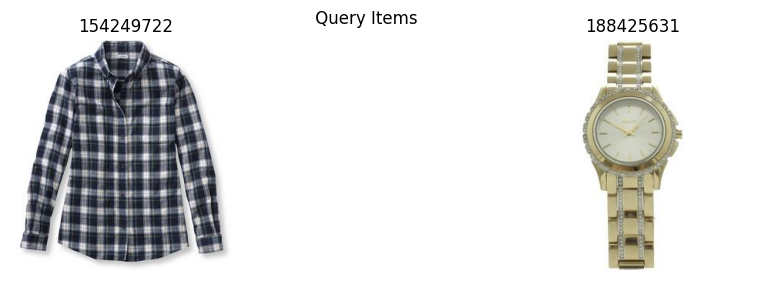

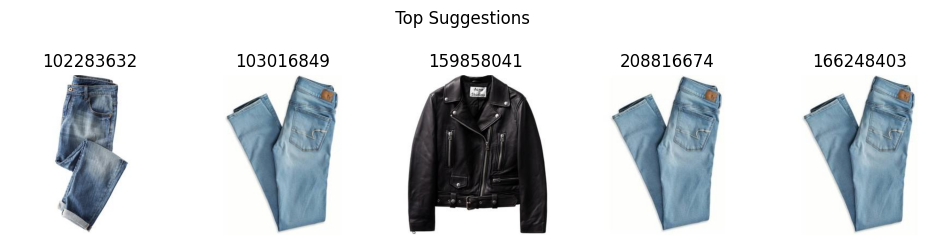


 Query Items: ['154249722', '188425631', '183214727']
→ Suggested: 159858041, Score: 0.9866
→ Suggested: 126777803, Score: 0.9808
→ Suggested: 192923471, Score: 0.9782
→ Suggested: 112600388, Score: 0.9774
→ Suggested: 165652957, Score: 0.9767


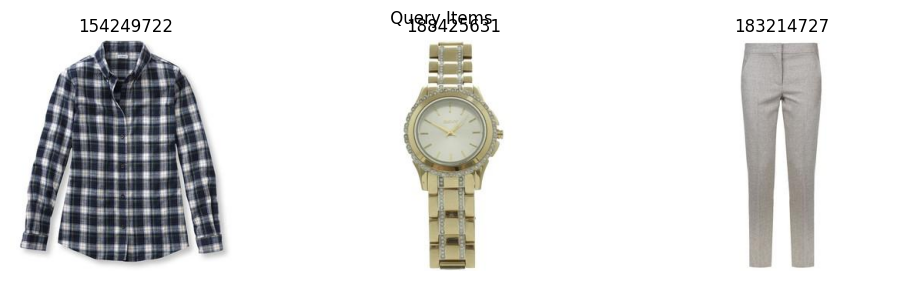

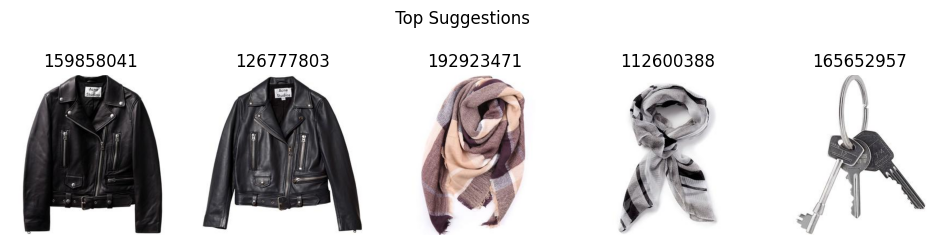


 Query Items: ['201813350', '195213892']
→ Suggested: 159102984, Score: 0.9683
→ Suggested: 70637427, Score: 0.9628
→ Suggested: 182203450, Score: 0.9623
→ Suggested: 202431025, Score: 0.9611
→ Suggested: 202219492, Score: 0.9610


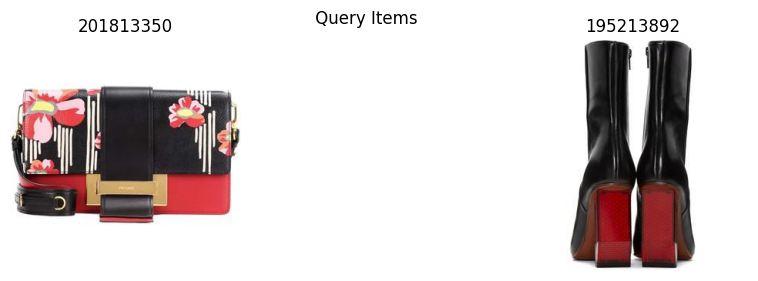

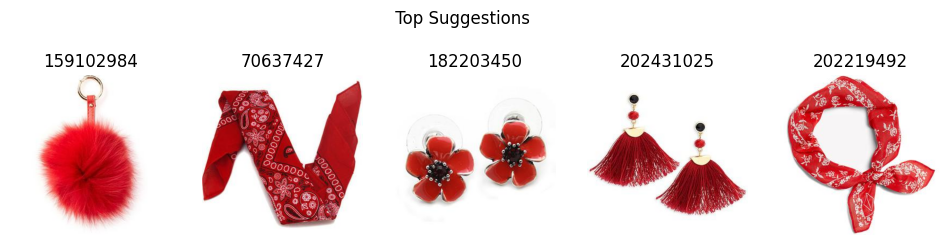


 Query Items: ['201813350', '195213892', '169020872']
→ Suggested: 202219492, Score: 0.9427
→ Suggested: 159102984, Score: 0.9416
→ Suggested: 98304682, Score: 0.9412
→ Suggested: 204618088, Score: 0.9409
→ Suggested: 186842280, Score: 0.9370


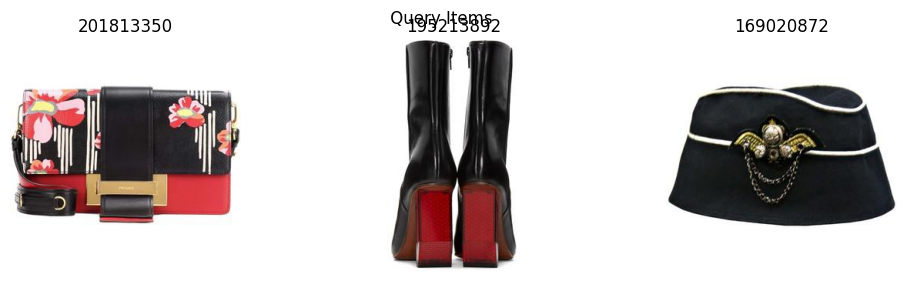

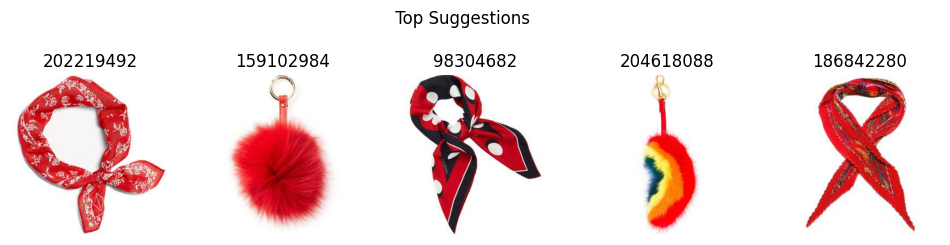


 Query Items: ['201799451', '194990026']
→ Suggested: 39109146, Score: 0.9593
→ Suggested: 209309557, Score: 0.9589
→ Suggested: 92748999, Score: 0.9588
→ Suggested: 204834908, Score: 0.9521
→ Suggested: 174652497, Score: 0.9517


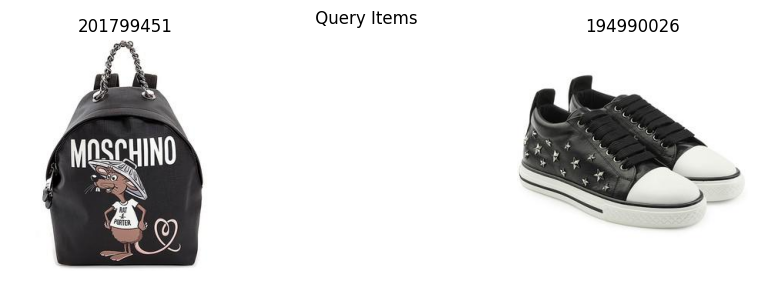

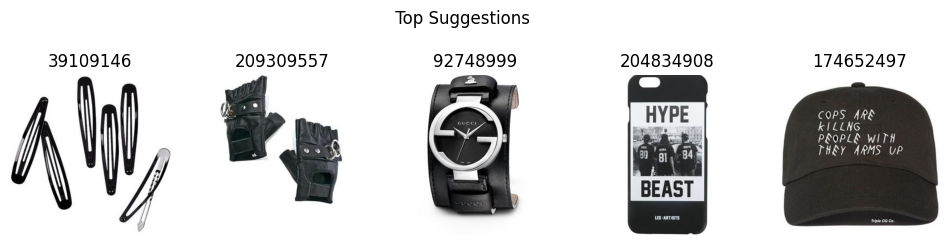


 Query Items: ['201799451', '194990026', '203786992']
→ Suggested: 81575588, Score: 0.9696
→ Suggested: 39109146, Score: 0.9685
→ Suggested: 159858041, Score: 0.9648
→ Suggested: 92748999, Score: 0.9642
→ Suggested: 209309557, Score: 0.9613


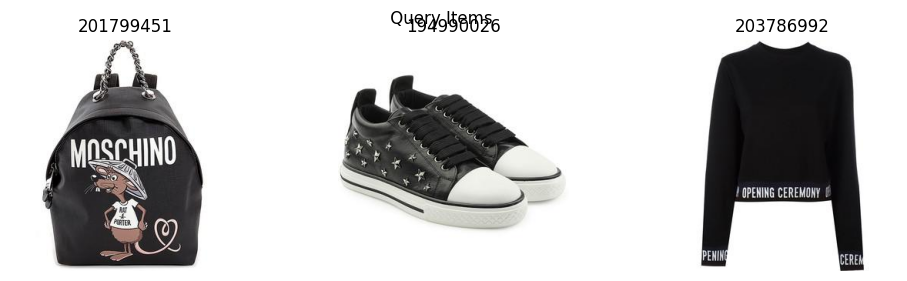

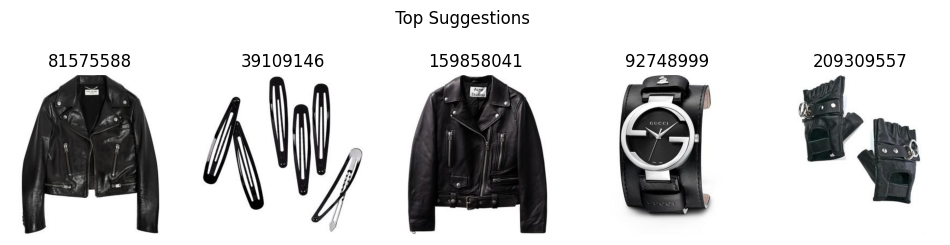

In [25]:
# Loop over multiple outfits in the train.json
for outfit in outfit_data[:3]:  # Use [:3] to limit to the first 3 outfits
    # Get item IDs in the outfit, filter those that exist in image_features
    item_ids = [item['item_id'] for item in outfit['items'] if item['item_id'] in image_features]

    if len(item_ids) < 3:
        continue  # Need at least 2 query + 1 for suggestion

    for j in range(1, 3):  # Using 1 and 2 items as query
        if len(item_ids) <= j:
            break
        query_items = item_ids[:j+1]

        top_matches = suggest_complement_from_features(query_items, image_features, compat_model, top_k=5)

        print(f"\n Query Items: {query_items}")
        for cid, score in top_matches:
            print(f"→ Suggested: {cid}, Score: {score:.4f}")
        
        # Show once per query group
        show_images(query_items, img_dir, title=" Query Items")
        show_images([cid for cid, _ in top_matches], img_dir, title=" Top Suggestions")


Enter 2-3 image IDs separated by commas:  100097445, 100141448



Query Items: ['100097445', '100141448']
→ Suggested: 144222414, Score: 0.9638
→ Suggested: 81575588, Score: 0.9573
→ Suggested: 159858041, Score: 0.9524
→ Suggested: 191372155, Score: 0.9465
→ Suggested: 133695692, Score: 0.9457


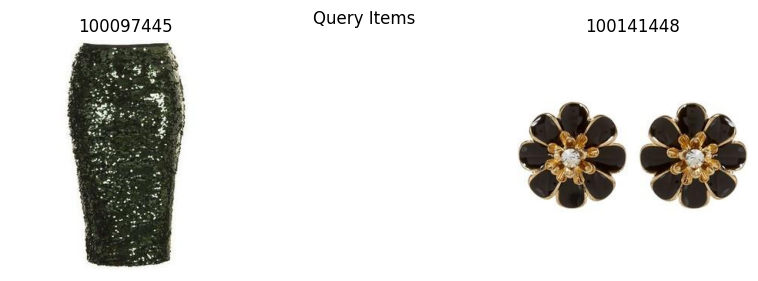

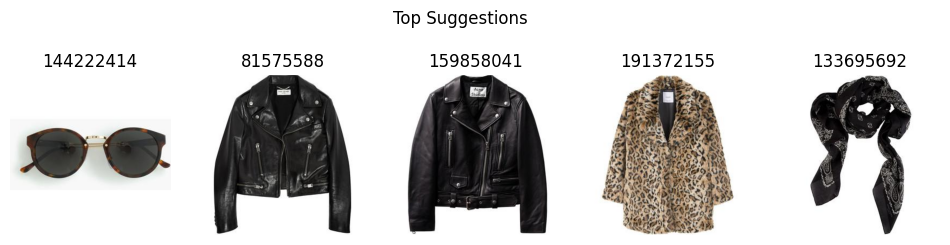

In [26]:
# Ask the user to input image IDs (comma-separated)
user_input = input("Enter 2-3 image IDs separated by commas: ")
query_items = [item.strip() for item in user_input.split(',')]

# Validate that all image IDs exist in the image features
query_items = [item_id for item_id in query_items if item_id in image_features]

if len(query_items) < 2:
    print("Please enter at least 2 valid image IDs that exist in the dataset.")
else:
    # Suggest complementary items using your model
    top_matches = suggest_complement_from_features(query_items, image_features, compat_model, top_k=5)

    print(f"\nQuery Items: {query_items}")
    for cid, score in top_matches:
        print(f"→ Suggested: {cid}, Score: {score:.4f}")

    # Display images
    show_images(query_items, img_dir, title="Query Items")
    show_images([cid for cid, _ in top_matches], img_dir, title="Top Suggestions")

In [27]:
# Ask the user to input image IDs (comma-separated)
user_input = input("Enter 2-3 image IDs separated by commas: ")
query_items = [item.strip() for item in user_input.split(',')]

# Validate that all image IDs exist in the image features
query_items = [item_id for item_id in query_items if item_id in image_features]

if len(query_items) < 2:
    print("Please enter at least 2 valid image IDs that exist in the dataset.")
else:
    # Suggest complementary items using your model
    top_matches = suggest_complement_from_features(query_items, image_features, compat_model, top_k=5)

    print(f"\nQuery Items: {query_items}")
    for cid, score in top_matches:
        print(f"→ Suggested: {cid}, Score: {score:.4f}")

    # Display images
    show_images(query_items, img_dir, title="Query Items")
    show_images([cid for cid, _ in top_matches], img_dir, title="Top Suggestions")

Enter 2-3 image IDs separated by commas:  100215754, 1000064078


Please enter at least 2 valid image IDs that exist in the dataset.


Enter 2-3 image IDs separated by commas:  100080548, 100295946



Query Items: ['100080548', '100295946']
→ Suggested: 187629361, Score: 0.9747
→ Suggested: 98345534, Score: 0.9670
→ Suggested: 181165647, Score: 0.9661
→ Suggested: 160101388, Score: 0.9641
→ Suggested: 192923471, Score: 0.9621


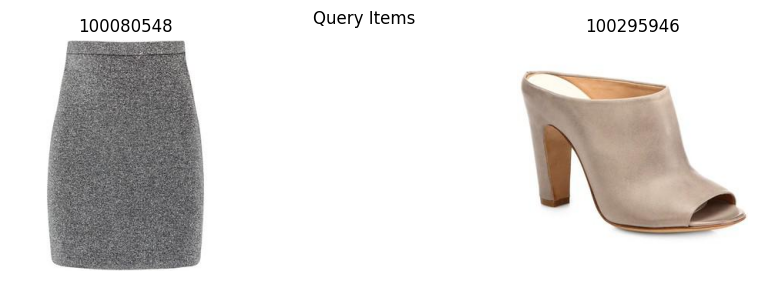

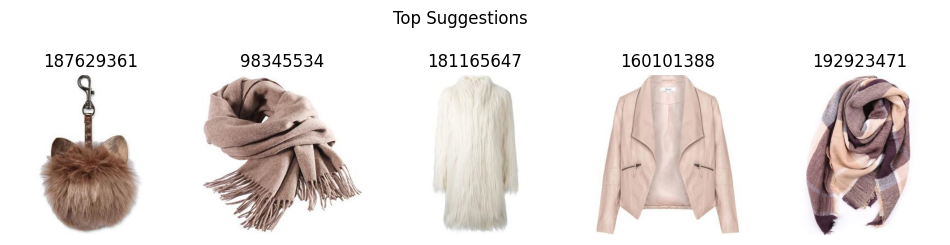

In [30]:
# Ask the user to input image IDs (comma-separated)
user_input = input("Enter 2-3 image IDs separated by commas: ")
query_items = [item.strip() for item in user_input.split(',')]

# Validate that all image IDs exist in the image features
query_items = [item_id for item_id in query_items if item_id in image_features]

if len(query_items) < 2:
    print("Please enter at least 2 valid image IDs that exist in the dataset.")
else:
    # Suggest complementary items using your model
    top_matches = suggest_complement_from_features(query_items, image_features, compat_model, top_k=5)

    print(f"\nQuery Items: {query_items}")
    for cid, score in top_matches:
        print(f"→ Suggested: {cid}, Score: {score:.4f}")

    # Display images
    show_images(query_items, img_dir, title="Query Items")
    show_images([cid for cid, _ in top_matches], img_dir, title="Top Suggestions")

In [31]:
# Save your trained model
torch.save(compat_model.state_dict(), "compat_model.pt")

# Save your image_features dict (e.g. extracted with ResNet)
import pickle
with open("image_features.pkl", "wb") as f:
    pickle.dump(image_features, f)


In [32]:
from IPython.display import FileLink

# Links for download
FileLink("compat_model.pt")  # for model weights
FileLink("image_features.pkl")  # for feature vectors


/kaggle/working/image_features.pkl

In [33]:
from IPython.display import FileLink

FileLink("compat_model.pt")  # For downloading model weights


/kaggle/working/compat_model.pt